# Florence-2

In [3]:
# !pip install flash-attn --no-build-isolation

  Using cached flash_attn-2.6.3.tar.gz (2.6 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.6.3-cp39-cp39-linux_x86_64.whl size=187308137 sha256=dcbc43553821df03e83eb4bc0778054d72f0bccaa26270565b09f4ca0b680576
  Stored in directory: /home/user/.cache/pip/wheels/77/9d/0b/cd6e5b1b80e010c9983988762d5e86dbd46e858ccd5d9d8226
Successfully built flash-attn


In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch
import requests
import copy
%matplotlib inline

In [2]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/home/user/miniconda3/envs/image-classification/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
processor?

Signature:     
processor(
    text: Union[str, List[str], List[List[str]]] = None,
    images: Union[ForwardRef('PIL.Image.Image'), numpy.ndarray, ForwardRef('torch.Tensor'), List[ForwardRef('PIL.Image.Image')], List[numpy.ndarray], List[ForwardRef('torch.Tensor')]] = None,
    tokenize_newline_separately: bool = True,
    padding: Union[bool, str, transformers.utils.generic.PaddingStrategy] = False,
    truncation: Union[bool, str, transformers.tokenization_utils_base.TruncationStrategy] = None,
    max_length=None,
    return_tensors: Union[str, transformers.utils.generic.TensorType, NoneType] = <TensorType.PYTORCH: 'pt'>,
    do_resize: bool = None,
    do_normalize: bool = None,
    image_mean: Union[float, List[float], NoneType] = None,
    image_std: Union[float, List[float], NoneType] = None,
    data_format: Optional[ForwardRef('ChannelDimension')] = 'channels_first',
    input_data_format: Union[str, ForwardRef('ChannelDimension'), NoneType] = None,
    resample: 'PILImageRes

In [5]:
model.generate?

Signature: model.generate(input_ids, inputs_embeds=None, pixel_values=None, **kwargs)
Docstring:
Generates sequences of token ids for models with a language modeling head.

<Tip warning={true}>

Most generation-controlling parameters are set in `generation_config` which, if not passed, will be set to the
model's default generation configuration. You can override any `generation_config` by passing the corresponding
parameters to generate(), e.g. `.generate(inputs, num_beams=4, do_sample=True)`.

For an overview of generation strategies and code examples, check out the [following
guide](../generation_strategies).

</Tip>

Parameters:
    inputs (`torch.Tensor` of varying shape depending on the modality, *optional*):
        The sequence used as a prompt for the generation or as model inputs to the encoder. If `None` the
        method initializes it with `bos_token_id` and a batch size of 1. For decoder-only models `inputs`
        should be in the format of `input_ids`. For encoder-deco

In [6]:
def run_example(task_prompt, image, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
        
    inputs = processor(
        text = prompt,
        images = image,
        return_tensors = 'pt').to('cuda', model.dtype)
    
    generated_ids = model.generate(
        input_ids=inputs['input_ids'].cuda(),
        pixel_values=inputs['pixel_values'].cuda(),
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3 # 빔 서치(Beam Search) 알고리즘에서 사용하는 매개변수, 빔의 개수를 의미하며, 숫자가 클수록 더 많은 후보 시퀀스를 동시에 탐색
    )
    
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answers = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )
    
    return parsed_answers

## Sample Image

In [7]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

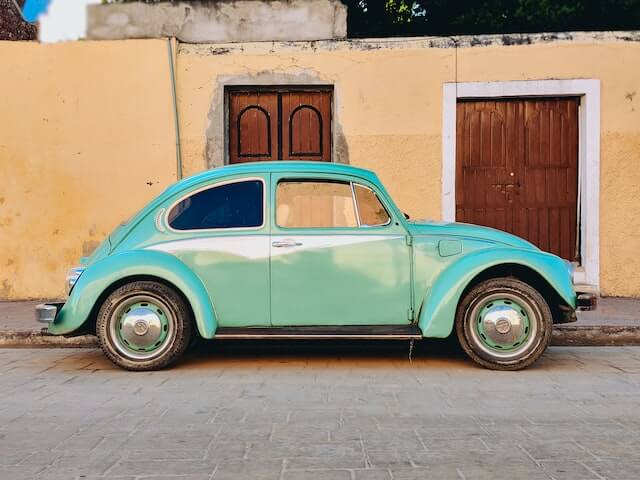

In [8]:
image

## Run pre-defined tasks without additional inputs

### Caption

In [9]:
task_prompt = '<CAPTION>'
run_example(task_prompt, image)

{'<CAPTION>': 'A green car parked in front of a yellow building.'}

In [10]:
task_prompt = '<DETAILED_CAPTION>'
run_example(task_prompt, image)

{'<DETAILED_CAPTION>': 'The image shows a green Volkswagen Beetle parked in front of a yellow building with two brown doors. The sky is a mix of blue and white, and there are a few green trees in the background.'}

In [11]:
task_prompt = '<MORE_DETAILED_CAPTION>'
run_example(task_prompt, image)

{'<MORE_DETAILED_CAPTION>': 'The image shows a vintage Volkswagen Beetle car parked on a cobblestone street in front of a yellow building with two wooden doors. The car is painted in a bright turquoise color and has a white stripe running along the side. It has two doors on either side of the car, one on top of the other, and a small window on the front. The building appears to be old and dilapidated, with peeling paint and crumbling walls. The sky is blue and there are trees in the background.'}

### Object Detection

In [13]:
task_prompt = '<OD>'
results = run_example(task_prompt, image)
print(results)

{'<OD>': {'bboxes': [[34.23999786376953, 160.0800018310547, 597.4400024414062, 371.7599792480469], [456.0, 97.68000030517578, 580.1599731445312, 261.8399963378906], [451.5199890136719, 276.7200012207031, 554.5599975585938, 370.79998779296875], [95.68000030517578, 280.55999755859375, 198.72000122070312, 371.2799987792969]], 'labels': ['car', 'door', 'wheel', 'wheel']}}


In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_bbox(image, data):
    fig, ax = plt.subplots()
    
    ax.imshow(image)
    
    for bbox, label in zip(data['bboxes'], data['labels']):
        x1, y1, x2, y2 = bbox
        
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        
        ax.add_patch(rect)
        
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
        
    ax.axis('off')
    
    plt.show()


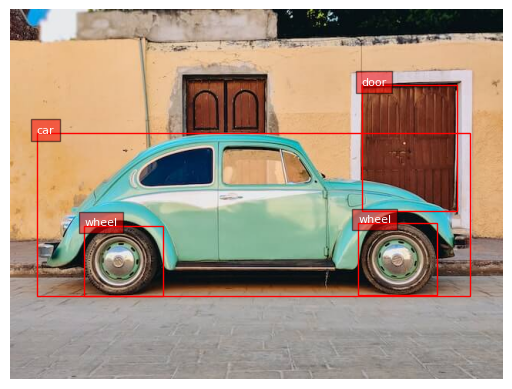

In [17]:
plot_bbox(image, results['<OD>'])

In [18]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = run_example(task_prompt, image)
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[33.599998474121094, 160.0800018310547, 596.7999877929688, 371.7599792480469], [450.8800048828125, 276.7200012207031, 553.2799682617188, 370.79998779296875], [95.04000091552734, 280.55999755859375, 197.44000244140625, 371.2799987792969]], 'labels': ['turquoise Volkswagen Beetle', 'wheel', 'wheel']}}


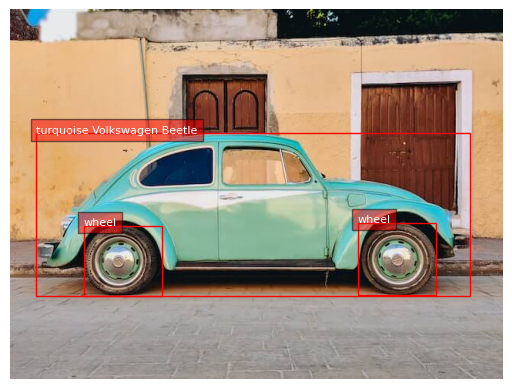

In [19]:
plot_bbox(image, results[f'{task_prompt}'])

In [20]:
task_prompt = '<REGION_PROPOSAL>'
results = run_example(task_prompt, image)
print(results)

{'<REGION_PROPOSAL>': {'bboxes': [[34.23999786376953, 160.0800018310547, 597.4400024414062, 371.7599792480469], [456.0, 97.68000030517578, 580.1599731445312, 261.8399963378906], [452.1600036621094, 276.7200012207031, 553.9199829101562, 370.79998779296875], [96.31999969482422, 280.55999755859375, 198.72000122070312, 371.2799987792969], [66.87999725341797, 266.6399841308594, 87.36000061035156, 295.91998291015625], [272.32000732421875, 241.67999267578125, 303.67999267578125, 246.95999145507812], [408.6399841308594, 308.3999938964844, 414.3999938964844, 320.8800048828125]], 'labels': ['', '', '', '', '', '', '']}}


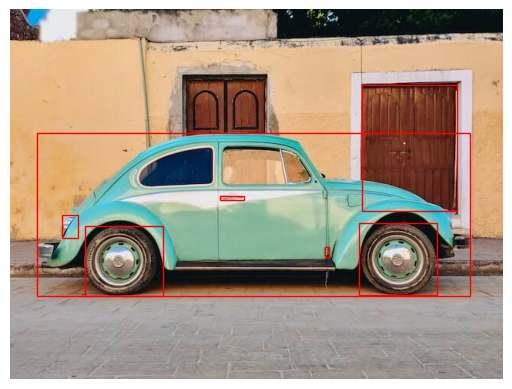

In [21]:
plot_bbox(image, results[f'{task_prompt}'])

### Phrase Grounding

In [22]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, image, text_input="A green car parked in front of a yellow building.")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[34.880001068115234, 158.63999938964844, 583.3599853515625, 374.6399841308594], [0.3199999928474426, 4.079999923706055, 639.0399780273438, 305.03997802734375]], 'labels': ['A green car', 'a yellow building']}}


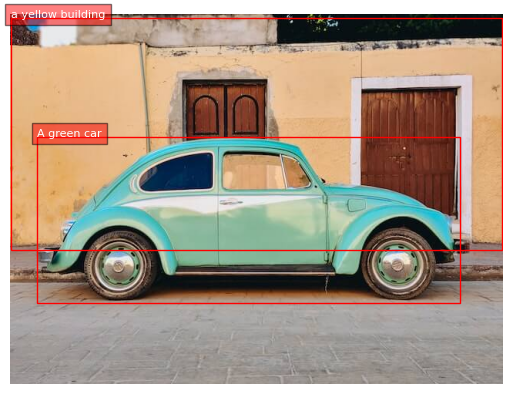

In [23]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

In [25]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, image, text_input="a green car")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[178.87998962402344, 181.67999267578125, 180.8000030517578, 180.72000122070312, 182.72000122070312, 180.72000122070312, 187.83999633789062, 177.83999633789062, 189.75999450683594, 177.83999633789062, 192.95999145507812, 175.9199981689453, 194.87998962402344, 175.9199981689453, 198.0800018310547, 174.0, 200.63999938964844, 173.0399932861328, 203.83999633789062, 172.0800018310547, 207.0399932861328, 170.63999938964844, 209.59999084472656, 169.67999267578125, 214.0800018310547, 168.72000122070312, 217.9199981689453, 167.75999450683594, 221.75999450683594, 166.8000030517578, 226.239990234375, 165.83999633789062, 230.72000122070312, 164.87998962402344, 237.1199951171875, 163.9199981689453, 244.1599884033203, 162.95999145507812, 253.1199951171875, 162.0, 265.2799987792969, 161.0399932861328, 311.3599853515625, 161.0399932861328, 329.2799987792969, 162.0, 338.239990234375, 162.95999145507812, 345.2799987792969, 163.9199981689453, 350.3999

### Referring expression segmentation

In [26]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, image, text_input="a green car")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[178.87998962402344, 181.67999267578125, 180.8000030517578, 180.72000122070312, 182.72000122070312, 180.72000122070312, 187.83999633789062, 177.83999633789062, 189.75999450683594, 177.83999633789062, 192.95999145507812, 175.9199981689453, 194.87998962402344, 175.9199981689453, 198.0800018310547, 174.0, 200.63999938964844, 173.0399932861328, 203.83999633789062, 172.0800018310547, 207.0399932861328, 170.63999938964844, 209.59999084472656, 169.67999267578125, 214.0800018310547, 168.72000122070312, 217.9199981689453, 167.75999450683594, 221.75999450683594, 166.8000030517578, 226.239990234375, 165.83999633789062, 230.72000122070312, 164.87998962402344, 237.1199951171875, 163.9199981689453, 244.1599884033203, 162.95999145507812, 253.1199951171875, 162.0, 265.2799987792969, 161.0399932861328, 311.3599853515625, 161.0399932861328, 329.2799987792969, 162.0, 338.239990234375, 162.95999145507812, 345.2799987792969, 163.9199981689453, 350.3999

In [27]:
from PIL import Image, ImageDraw, ImageFont 
import random
import numpy as np

colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']

def draw_polygon(image, prediction, fill_mask=False):
    
    draw = ImageDraw.Draw(image)  
    
    scale = 1
    
    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        
        color = random.choice(colormap)
        fill_color = random.choice(colormap) if fill_mask else None
        
        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)  
            if len(_polygon) < 3:  
                print('Invalid polygon:', _polygon)  
                continue  
              
            _polygon = (_polygon * scale).reshape(-1).tolist()
            
            if fill_mask:
                

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viri